## PySpark Setup! 
Extract Spark/Hadoop and install PyPython dependencies

In [ ]:
! pip install spark-nlp==4.2.4 pyspark==3.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Connect to google drive and unzip the dataset!

Getting ready with the dataset to be used.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip /content/gdrive/Shareddrives/ukraine-russia/ukraine-russia.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/gdrive/Shareddrives/ukraine-russia/ukraine-russia.zip
replace ukraine-russia/08.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ukraine-russia/08.csv   
replace __MACOSX/ukraine-russia/._08.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/ukraine-russia/._08.csv  
replace ukraine-russia/09.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ukraine-russia/09.csv   
replace __MACOSX/ukraine-russia/._09.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/ukraine-russia/._09.csv  
replace ukraine-russia/02.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ukraine-russia/02.csv   y
y

replace __MACOSX/ukraine-russia/._02.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: __MACOSX/ukraine-russia/._02.csv  
replace ukraine-russia/03.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflat

## Create a Spark Session!

Standard initialization for the Spark session within colab.

In [ ]:
import sparknlp

spark = sparknlp.start()

spark

## Importing the utility functions!

Pyspark functions, wordcloud, pandas, etc.

In [ ]:
## Pyspark Functions
import pyspark.sql.functions as F
from pyspark.sql.functions import lit
from pyspark.ml import Pipeline
from pyspark.sql import types as T

## Data Cleaning functions
from sparknlp.base import DocumentAssembler
from sparknlp.base import Finisher
from sparknlp.annotator import Tokenizer
from sparknlp.annotator import Normalizer
from sparknlp.annotator import LemmatizerModel 
from sparknlp.annotator import StopWordsCleaner
from sparknlp.annotator import NGramGenerator
from sparknlp.annotator import PerceptronModel

## WordCloud
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
nltk.download('stopwords')
eng_stopwords = stopwords.words('english')

## Python libraries to implement the code in python for performance evaluation
import pandas as pd
import seaborn as sns
import numpy as np
import sparknlp
import re
import string
import time

## Functions used for plotting
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Cleaning Functions
Function definations used for cleaning the data in **Pyspark** and **Python**.

In [ ]:
## Function used to clean the data in Python.
def python_clean(text):
    stemmer = nltk.SnowballStemmer("english")  
    stopword=set(stopwords.words('english'))
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

## Function used to clean the data in PySpark.
def pyspark_clean(inp_df):
    inp_df = inp_df.filter(inp_df.text.isNotNull())
    columnName = 'text'
    clean_df = df.select(columnName).filter(F.col(columnName).isNotNull())
    clean_df = clean_df.withColumn(columnName, F.lower(columnName));
    clean_df = clean_df.withColumn('text', F.regexp_replace('text', r"\[.*?\]", ''))
    clean_df = clean_df.withColumn('text', F.regexp_replace('text', r"https?://\S+|www\.\S+", ''))
    clean_df = clean_df.withColumn('text', F.regexp_replace('text', r"<.*?>+", ''))
    clean_df = clean_df.withColumn('text', F.regexp_replace('text', '\n', ''))
    clean_df = clean_df.withColumn('text', F.regexp_replace('text', "\w*\d\w*", ''))
    clean_df = clean_df.withColumn('text', F.regexp_replace('text', '#', ''))
    clean_df = clean_df.withColumn('text', F.regexp_replace('text', 'RT', ''))
    clean_data = clean_df.withColumn('text', F.regexp_replace('text', ':', ''))

    documentAssembler = DocumentAssembler() \
       .setInputCol(columnName) \
       .setOutputCol('document')

    tokenizer = Tokenizer() \
       .setInputCols(['document']) \
       .setOutputCol('tokenized')

    normalizer = Normalizer() \
       .setInputCols(['tokenized']) \
       .setOutputCol('normalized') \
       .setLowercase(True)

    lemmatizer = LemmatizerModel.pretrained() \
       .setInputCols(['normalized']) \
       .setOutputCol('lemmatized')

    stopwords_cleaner = StopWordsCleaner() \
       .setInputCols(['lemmatized']) \
       .setOutputCol('unigrams') \
       .setStopWords(eng_stopwords)

    ngrammer = NGramGenerator() \
      .setInputCols(['lemmatized']) \
      .setOutputCol('ngrams') \
      .setN(3) \
      .setEnableCumulative(True) \
      .setDelimiter('_')

    pos_tagger = PerceptronModel.pretrained('pos_anc') \
      .setInputCols(['document', 'lemmatized']) \
      .setOutputCol('pos')

    finisher = Finisher() \
       .setInputCols(['unigrams', 'ngrams', 'pos']) 
  
    pipeline = Pipeline() \
       .setStages([documentAssembler,                  
                 tokenizer,
                 normalizer,                  
                 lemmatizer,                  
                 stopwords_cleaner, 
                 pos_tagger,
                 ngrammer,  
                 finisher])
     
    processed_tweet = pipeline.fit(clean_data).transform(clean_data)
    return processed_tweet.select("text")


## WordCloud generation and plotting Functions
Function definations used for generating and plotting the wordcloud from user data in **Pyspark** and **Python**.

In [ ]:
def pyspark_wordcloud_generation(month,df):
  new_df = df.select('*', lit(0.25).alias("key_val"))
  new_df = new_df.groupBy("key_val").agg(F.collect_list("text").alias("merged_data"))
  result = new_df.first()['merged_data']
  text = " ".join(i for i in result)
  stopwords = set(STOPWORDS)
  # Adding few specific words to be removed from the cloud.
  stopwords.add("https")
  stopwords.add("nan")
  stopwords.add("en'")
  stopwords.add("el")
  stopwords.add("de")
  stopwords.add("la")
  stopwords.add("la")
  stopwords.add("t")
  stopwords.add("co")
  wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text)

def python_wordcloud_generation(month,data):
  text = " ".join(i for i in data.text)
  stopwords = set(STOPWORDS)
  # Adding few specific words to be removed from the cloud.
  stopwords.add("https")
  stopwords.add("nan")
  stopwords.add("en'")
  stopwords.add("el")
  stopwords.add("de")
  stopwords.add("la")
  stopwords.add("la")
  stopwords.add("t")
  stopwords.add("co")
  wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text)
  plt.figure(figsize=(15,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


## Output Cell!

We load the data for each month, clean the data for that month and plot the wordcloud for that month.

This is done in python followed by pyspark.

It keeps track of the time for each month evaluation and the number of tweets for each month.

Populate the dataframe with number of tweets, python timing for each month and pyspark timing for each month for data cleaning and cloud generation.

This is further used to plot the graph to show the performance improvement with distributed model(PySpark) over Python.


In [ ]:
months = [ "02","03","05", "06", "07", "08","09"]
tweet_list = []
python_time = []
pyspark_time = []

for month in months:
  start = time.time()
  df = pd.read_csv(f"./ukraine-russia/{month}.csv",engine='python')
  result_df = df[df['language'] == "en"]
  data = result_df[["username", "text", "language"]] 
  data = data.dropna(how='all')  # Drop Row/Column Only if All the Values are Null 
  data["text"] = data["text"].apply(python_clean)
  python_wordcloud_generation(month,data)
  end = time.time()
  python_time.append(end - start)

for month in months:
  start = time.time()
  df = spark.read.csv(f"./ukraine-russia/{month}.csv", header=True,  inferSchema=True)
  df = df.filter(F.col("language")=="en")
  tweet_list.append(df.count())
  df.persist()
  processed_tweets = pyspark_clean(df)
  pyspark_wordcloud_generation(month,processed_tweets)
  end = time.time()
  pyspark_time.append(end - start)

p = pd.DataFrame({})
p["Tweet Count"] = tweet_list
p["Python"] = python_time
p["PySpark"] = pyspark_time


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
lemma_antbnc download started this may take s

## Plotting performance graph!

Plot the graph to show the performance improvement with distributed model(**PySpark**) over **Python**.
 

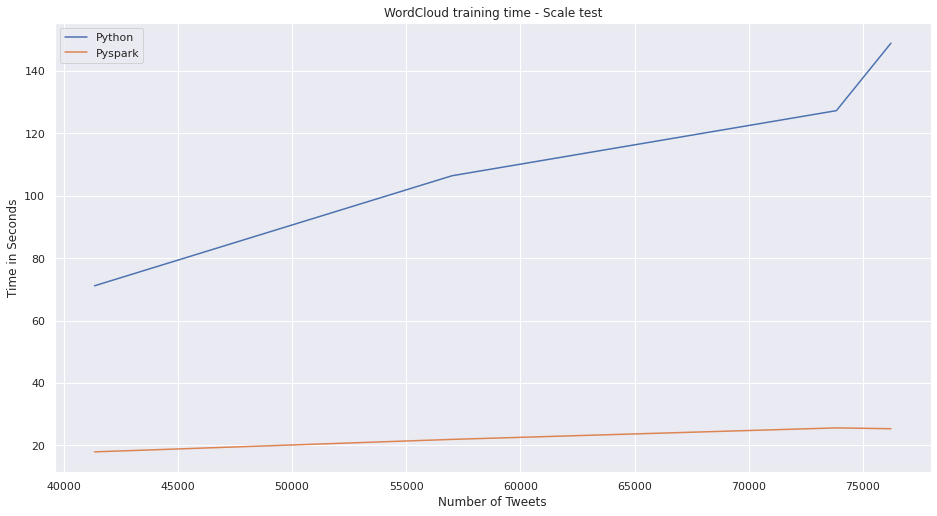

In [ ]:
p = pd.DataFrame({})
p["Tweet Count"] = tweet_list
p["Python"] = python_time
p["PySpark"] = pyspark_time
p.sort_values(["Tweet Count"],inplace=True);
print(p)
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})

# loading dataset
  
# draw lineplot
sns.lineplot(x="Tweet Count", y="Python", data=p[:4],  label="Python")
sns.lineplot(x="Tweet Count", y="PySpark", data=p[:4],  label="Pyspark")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of Tweets")
plt.title('WordCloud training time - Scale test')
plt.show()